In [1]:
# set theme
!jt -t oceans16

In [2]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'

### Import needed modules

In [3]:
import numpy as np
import xarray as xr
import scipy.interpolate as spint
import os
import glob

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

import ipdb

# from pylab import *
from matplotlib import dates

from datetime import datetime, timedelta
from datetime import date

import cmocean
import matplotlib.dates as mdates

# import holteandtalley as ht
import gsw

from bgc import plot_bbp, plot_flags, medfilt1

# from BGC_Argo_BBP_RTQC import BBP_Spike_test, global_range_test_BBP700
# from BGC_Argo_BBP_RTQC import global_range_test_BBP700 #, BBP_Spike_test

import subprocess

import warnings
warnings.filterwarnings('ignore')
    
# import inspect #https://www.stefaanlippens.net/python_inspect/
import pickle

import gc
from parfor import pmap



In [4]:
# function to define adaptive median filtering based on Christina Schallemberg's suggestion for CHLA
def adaptive_medfilt1(x, y, PLOT=False):
    # applies a median filtering followin Christina Schlallemberb's recommendations
    # x is PRES
    # y is BBP
    
    
#     x = PRES[innan]
#     y = BBP700[innan]

    # compute x resolution
    xres = np.diff(x)

    # initialise medfiltered array
    ymf = np.zeros(y.shape)*np.nan

    ir_LT1 = np.where(xres<1)[0]
    if np.any(ir_LT1):
        win_LT1 = 11.
        ymf[ir_LT1] = medfilt1(y[ir_LT1], win_LT1)   

    ir_13 = np.where((xres>=1) & (xres<=3))[0]
    if np.any(ir_13):
        win_13 = 7.
        ymf[ir_13] = medfilt1(y[ir_13], win_13)   

    ir_GT3 = np.where(xres>3)[0]
    if np.any(ir_GT3):
        win_GT3 = 5.
        ymf[ir_GT3] = medfilt1(y[ir_GT3], win_GT3)   

    if PLOT:
        plt.plot(np.log10(y), x, 'o')
        plt.plot(np.log10(ymf), x, 'r-')
    
    return ymf


# Implement different RTQC for BBP data using B-files

## Tests that do not remove the entire profile

### GLOBAL RANGE TEST (test order code "A")
<br>
#### Objective:
To detect and flag values of BBP532 and BBP700 that are outside the expected range.
<br>
<br>
#### What is done:
Check that:<br>
<code> medfilt1(BBP700) </code>  is in range [0, 0.001] m$^{-1} $.<br>
<code> medfilt1(BBP532) </code> is in range [0, 0.001] m$^{-1} $.<br>
<br>
The value of <code>A_MAX_BBP700=0.001</code> is taken as a very conservative estimate based on histograms in fig 2 of Bisson et al., 2019, 10.1364/OE.27.030191
<br>
<br>
#### QC flag if test fails
3
<br>
Note: the entire profile is flagged, if any negative point is found (because if there is a negative value, then
it is worth looking at the profile during DMQC).
<br>
__________________________________________________________________________________________


In [5]:
##################################################################
##################################################################
# test parameters defined outside function to make them global variables
A_MIN_BBP700 = 0 # [1/m]
A_MAX_BBP700 = 0.01 # [1/m] REVISED VALUE (very conservative estimate based on histograms in fig 2 of Bisson et al., 2019, 10.1364/OE.27.030191)
#     MAX_BBP700 = 0.1 # [1/m] NOTE that at least for BBP700 in 6901152, this value is above the saturation of the instrument (~0.077 1/m)

def BBP_Global_range_test(BBP, BBPmf1, PRES, QC_Flags, QC_1st_failed_test, fn, VERBOSE=False, PLOT=False):
    # BBP: nparray with all BBP data
    # BBPmf1: median-filtered BBP data
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # fn: name of corresponding B-file
    #
    # WHAT IS DONE: Then this tests fails, only the failing points are flagged (QC=3)
   
    FORCE_PLOT = False # this is to plot even if the test does not fails
    
    QC = 3
    QC_TEST_CODE = 'A'    
#     ISBAD = np.array([])
    ISBAD = np.zeros(len(BBPmf1), dtype=bool) # flag for noisy profile

     
    # this is the test 
    ibad = np.where( (BBPmf1 > A_MAX_BBP700) | (BBPmf1 < A_MIN_BBP700) )[0]
    ISBAD[ibad] = 1
    if np.any(ISBAD==1): # If ISBAD is not empty
        # flag entire profile if any negative value is found
        if np.any(BBPmf1 < A_MIN_BBP700):
            ISBAD = np.where(BBPmf1)

        # apply flag
        QC_Flags[ISBAD] = QC
        QC_1st_failed_test[ISBAD] = QC_TEST_CODE
        
        if VERBOSE:
            print('Failed Global_Range_test')
            print('applying QC=' + str(QC) + '...')
            
        if PLOT:
            plot_failed_QC_test(BBP, BBPmf1, PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE, FORCE_PLOT)
        
    return QC_Flags, QC_1st_failed_test


### SURFACE HOOK TEST (test order code "D")
<br>
#### Objective:
To detect and flag values of BBP532 and BBP700 that are negative near the surface.
<br>
<br>
#### What is done:
Check that:<br>
<code> BBP700 </code>  is greater than 0 m$^{-1}$ in the top 5 dbars.<br>
<code> BBP532 </code>  is greater than 0 m$^{-1}$ in the top 5 dbars.<br>
<br>
This test is needed because the medfilt1(BBP) used in the Global Range Test remove these few negative values near the surface. 
This likely needed because of some miscalibration in the pressure that cause the BBP meter to collect data outside of the water.
<br>
<br>
#### QC flag if test fails
3
<br>
<br>
__________________________________________________________________________________________


In [6]:
##################################################################
##################################################################
# test parameters defined outside function to make them global variables
D_MIN_BBP700 = 0 # [1/m]
D_ISURF = 5 # [dbars] pressure threshold above which to check for negative values

def BBP_Surface_hook_test(BBP, BBPmf1, PRES, QC_Flags, QC_1st_failed_test, fn, VERBOSE=False, PLOT=False):
    # BBP: nparray with all BBP data
    # BBPmf1: median-filtered BBP data
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # fn: name of corresponding B-file
    #
    # WHAT IS DONE: Then this tests fails, only the failing points are flagged (QC=3)
   
    FORCE_PLOT = False # this is to plot even if the test does not fails
    
    QC = 3
    QC_TEST_CODE = 'D'    
    ISBAD = np.zeros(len(BBPmf1), dtype=bool) # initialise flag
    iSURF  = np.where(PRES<=D_ISURF)[0]
     
    # this is the test 
    ibad = np.where(  (BBP[iSURF] < D_MIN_BBP700) )[0]
    ISBAD[ibad] = 1
    if np.any(ISBAD==1): # If ISBAD is not empty
        # apply flag
        QC_Flags[ISBAD] = QC
        QC_1st_failed_test[ISBAD] = QC_TEST_CODE
        
        if VERBOSE:
            print('Failed Surface_hook_test')
            print('applying QC=' + str(QC) + '...')
            
        if PLOT:
            plot_failed_QC_test(BBP, BBPmf1, PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE, FORCE_PLOT)
        
    return QC_Flags, QC_1st_failed_test


## Tests that flag the entire profile

### NEGATIVE NON-SURFACE TEST (test order code "F")
<br>
#### Objective:
To detect and flag values of BBP532 and BBP700 that are negative below the surface.
<br>
<br>
#### What is done:
Check that:<br>
<code> BBP700 </code>  is less than 0 m$^{-1}$ below 5 dbars.<br>
<code> BBP532 </code>  is less than 0 m$^{-1}$ below 5 dbars.<br>
<br>
This test is needed because the medfilt1(BBP) used in the Global Range Test remove these few negative values near the surface. 
<br>
<br>
#### QC flag if test fails
3
<br>
<br>
__________________________________________________________________________________________


In [7]:
##################################################################
##################################################################
# test parameters defined outside function to make them global variables
# D_MIN_BBP700 = 0 # [1/m]
# D_ISURF = 5 # [dbars] pressure threshold above which to check for negative values

def BBP_Negative_nonsurface_test(BBP, PRES, QC_Flags, QC_1st_failed_test, fn, VERBOSE=False, PLOT=False):
    # BBP: nparray with all BBP data
    # BBPmf1: median-filtered BBP data
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # fn: name of corresponding B-file
    #
    # WHAT IS DONE: Then this tests fails, only the failing points are flagged (QC=3)
    FORCE_PLOT = False # this is to plot even if the test does not fails

    QC = 3
    QC_TEST_CODE = 'F'    
#     ISBAD = np.zeros(len(BBPmf1), dtype=bool) # initialise flag
    ISBAD = np.array([])
    iDEEP  = np.where( PRES > D_ISURF )[0]
     
    # this is the test 
    if np.any( np.where((BBP[iDEEP] < D_MIN_BBP700))[0] ):
        ISBAD = 1
        iQChigher = np.where(QC_Flags < QC) 
        if iQChigher:
            if VERBOSE:
                print('Failed BBP_Negative_nonsurface_test')
                print('applying QC=' + str(QC) + '...')
                
            QC_Flags[iQChigher] = QC
            QC_1st_failed_test[iQChigher] = QC_TEST_CODE
            
        if ((ISBAD==1) & (PLOT==True)) | (FORCE_PLOT==True):
            plot_failed_QC_test(BBP, BBPmf1, PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE, FORCE_PLOT)
        
    return QC_Flags, QC_1st_failed_test


### BBP NOISY-PROFILE TEST  (test order code "B")
<br>
#### Objective:
To detect and flag profiles of BBP that are affected by noisy data.
<br><br>
#### What is done:
Compute <code> res = abs(BBP-medfilt1(BBP, 31))</code>.

Flag profiles where at least <code>15%</code> of the profile has <code>res > 0.001</code>  m$^{-1}$.<br>
<br><br>
#### QC flag if test fails
3
<br>
__________________________________________________________________________________________

In [8]:
##################################################################
##################################################################
B_RES_THRESHOLD = 0.001 # [1/m] threshold for relative residuals
B_FRACTION_OF_PROFILE_THAT_IS_OUTLIER = 0.15 # fraction of profile with relative residuals above REL_RES_THRESHOLD

def BBP_Noisy_Profile_test(BBP, BBPmf1, PRES, QC_Flags, QC_1st_failed_test, fn, VERBOSE=False, PLOT=True):
    # BBP: nparray with all BBP data
    # BBPmf1: smooth BBP array (medfilt1(BBP700, 31)
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # fn: name of corresponding B-file
    #
    # WHAT IS DONE: When the test fails, all points in the profile are flagged (QC=3)
    
    QC = 3; # flag to apply if the result of the test is true
    QC_TEST_CODE = 'B'
    ISBAD = np.array([]) # flag for noisy profile
    
    FORCE_PLOT = False # plot even if the test does not fail (used when developing the test)

#     rel_res = np.empty(BBP.shape)
#     rel_res[:] = np.nan
    
    res = np.empty(BBP.shape)
    res[:] = np.nan
    


    innan = np.where(~np.isnan(BBP))[0]
    
    if len(innan)>10: # if we have at least 10 points in the profile
        res[innan] = np.abs(BBP[innan]-BBPmf1[innan])
        ioutliers = np.where(abs(res)>B_RES_THRESHOLD)[0] # index of where the rel res are greater than the threshold

        if len(ioutliers)/len(innan)>=B_FRACTION_OF_PROFILE_THAT_IS_OUTLIER: # this is the actual test: are there more than a certain fraction of points that are noisy?
            ISBAD = ioutliers

    # update QC_Flags to 3 when bad profiles are found
    if len(ISBAD)>0:     
        iQChigher = np.where(QC_Flags < QC) 
        if iQChigher:
            if VERBOSE:
                print('Failed BBP_Noisy_Profile_test')
                print('applying QC=' + str(QC) + '...')
                
            QC_Flags[iQChigher] = QC
            QC_1st_failed_test[iQChigher] = QC_TEST_CODE

    if ((len(ISBAD)>0) & (PLOT==True)) | (FORCE_PLOT==True):
        plot_failed_QC_test(res, res*0., PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE, FORCE_PLOT)

    
    return QC_Flags, QC_1st_failed_test, res


### BBP HIGH-DEEP-VALUES TEST  (test order code "C")
<br>
#### Objective:
To detect and flag profiles of BBP that have at least some (5) points anomalously high values at depth. It could indicate multiple problems: wrong calibration coefficients, biofouling, bad sensor, grounding, etc.
<br><br>
#### What is done:
Check if <code>median(BBP700)</code> below <code>800 dbars</code> is above a threshold of <code>0.0005 </code> m$^{-1}$.  (this is half the value typical for surface bbp in the oligotrophic ocean, smoothed bbp data at depth are expected to be lower than this value).

Flag entire profile.
<br><br>
#### QC flag if test fails
3
<br>
__________________________________________________________________________________________

In [9]:
##################################################################
##################################################################
C_DEPTH_THRESH = 800 #[dbars] below this threshold we consider it "deep"
C_DEEP_BBP700_THRESH = 0.0005 # [1/m] threshold for bbp at depth
C_N_of_ANOM_POINTS = 5 # number of anomalous points required for the test to fail

def BBP_High_Deep_Values_test(BBPmf1, PRES, QC_Flags, QC_1st_failed_test, fn, VERBOSE=False, PLOT=True):
    # BBP: nparray with all BBP data
    # BBPmf1: smooth BBP array (medfilt1(BBP700, 31)
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # fn: name of corresponding B-file
    #
    # WHAT IS DONE: When the test fails, all points in the profile are flagged (QC=3)

    FORCE_PLOT = False # this is to plot even if the test does not fails
        
    QC = 3; # flag to apply if the result of the test is true
    QC_TEST_CODE = 'C'
    ISBAD = np.zeros(len(BBPmf1), dtype=bool) # flag for noisy profile
    
    # this is the test 
    iDEEP = np.where(PRES>C_DEPTH_THRESH)
    if (np.nanmedian(BBPmf1[iDEEP]) > C_DEEP_BBP700_THRESH) & ( len(BBPmf1[iDEEP]) >= C_N_of_ANOM_POINTS):
        ISBAD = np.ones(len(BBPmf1), dtype=bool)
    
    if np.any(ISBAD==1): # if ISBAD, then apply QC_flag=3  
        iQChigher = np.where(QC_Flags < QC) # but first check that there are no QCflags > than the one we want to assign in this profile
        if iQChigher:
            if VERBOSE:
                print('Failed High_Deep_Values_test')
                print('applying QC=' + str(QC) + '...')

                
            QC_Flags[iQChigher] = QC
            QC_1st_failed_test[iQChigher] = QC_TEST_CODE

            if PLOT:
                plot_failed_QC_test(BBPmf1, BBPmf1, PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE, FORCE_PLOT)


 
    return QC_Flags, QC_1st_failed_test


### BBP MISSING-DATA TEST  (test order code "E")
<br>
#### Objective:
To detect and flag profiles of BBP that have a large fraction of missing data. This test can also detect profiles that are too shallow with respect to the Argo mission.
<br>
<br>
#### What is done:
Ensure that we have at least 1 measurements every 100 dbars in the upper 1000 dbars.

Flag entire profile.
<br><br>
#### QC flag if test fails
1 if shallow profile: then do not flag as failing test<br>
2 if continuous bins from the surface<br>
3 if less than 2 data points in 100-dbar bins from 0 to 1000 dbars (because there maybe good profiles that are shallower than 1000 dbars)<br>
4 if only data within one bin
<br>
__________________________________________________________________________________________

In [16]:
##################################################################
##################################################################
def BBP_Missing_Data_test(BBP, PRES, QC_Flags, QC_1st_failed_test, fn, VERBOSE=False, PLOT=True):
    # BBP: nparray with all BBP data
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # fn: name of corresponding B-file
    #
    # WHAT IS DONE: When the test fails, all points in the profile are flagged (QC=2)
    
    FORCE_PLOT = False # this is to plot even if the test does not fails
        
    QC_all = [np.nan, np.nan, np.nan, np.nan]    
    QC_all[0] = 2 # flag to apply if we have less than 10 consecutive bins from the surface
    QC_all[1] = 3 # flag to apply if the result of the test is true
    QC_all[2] = 4 # flag to apply if there are data only within one size bin
    QC_all[3] = 2 # if shallow profile
    QC_TEST_CODE = 'E'
    MIN_N_PERBIN = 1 # minimum number of points in each bin
    ISBAD = 0 # flag for noisy profile
    
    # this is the test (check also that the corresponding flag have not been changed from the initial QC=1)
    # bin the profile into 100-dbars bins
    bins = np.linspace(50, 1000, 10) # create 10 bins between 0 and 1000 dbars
    PRESbin = np.digitize(PRES, bins) # assign PRES values to each bin
    bin_counts = np.zeros(bins.shape)*np.nan
    for i in range(len(bins)):
        if i==0:
            bin_counts[i] = len(np.where(PRES<bins[i])[0])
        else:
            bin_counts[i] = len(np.where((PRES>=bins[i-1]) & (PRES<bins[i]))[0])
            

    # this is the actual test
    if np.any(np.nonzero(bin_counts<MIN_N_PERBIN)[0]):
        ISBAD = 1  
        
        # these statement below are for QC=2
        nonempty = np.where(bin_counts>0)[0] # index of bins with data inside
        if len(nonempty)>1:
            test_bin = np.linspace(0, nonempty[-1], nonempty[-1]+1) # create array with consecutive indices from 0 to the last element of nonempty
            # if there is only one bin with data then QC=4
            if len(np.nonzero(bin_counts>MIN_N_PERBIN)[0])==1: 
                print("data only in one bin: QC=4")
                QC = QC_all[2]

            # if there are consecutive bins from zero index 
            # and if not all bins contain data, then QC=2    
            elif (np.all(test_bin==nonempty)) & (nonempty[-1]<9) & (np.nanmax(PRES) >= bins.max()): 
                print("shallow profile due to missing data: QC=2")
                QC = QC_all[0]
                
            # check if max(PRES)<maxPresbin to decide if this was a profile that was programmed to be shallow
            elif (np.all(test_bin==nonempty)) & (nonempty[-1]<9) & (np.nanmax(PRES) < bins.max()): 
                print("shallow profile (maxPRES="+str(np.nanmax(PRES))+" dbars): QC=2")
                # set ISBAD so that the test does not fail when it's a shallow profile
#                 ISBAD = 0
                QC = QC_all[3]
                    

            # if missing data in the profile, but not cosecutively from bottom, QC=3        
            else:
                print("data in some bins missing: QC=3")
                QC = QC_all[1]
                
        else: # this is for when we have no data at all, QC=4
            print("no data at all: QC=4")
            QC = QC_all[2]


                
    if ISBAD==1: # if ISBAD, then apply QC_flag  
        iQChigher = np.where(QC_Flags < QC) # but first check that there are no QCflags > than the one we want to assign in this profile
        if iQChigher:
            if VERBOSE:
                print('Failed Missing_Data_test')
                print('applying QC=' + str(QC) + '...')

                
            QC_Flags[iQChigher] = QC
            QC_1st_failed_test[iQChigher] = QC_TEST_CODE

            if PLOT:
                plot_failed_QC_test(BBP, bin_counts, PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE, FORCE_PLOT)


    return QC_Flags, QC_1st_failed_test


## Apply tests

### Create lists of WMOs that include BBP meters on different float types

In [11]:
MAIN_DIR = '/data/datasets/Argo/Original/'
WORKING_DIR = '/fast_scratch/BGCArgo_plot/source/'

base_cmdo = "grep BBP700 " + MAIN_DIR + "dac/argo_bio-profile_index.txt | cut -d '/'"
# cmdo = base_cmdo + " -f2 | uniq"

# WMO = subprocess.run(cmdo, shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').split('\n')


# cmdo2 = base_cmdo + " -f1,2 | uniq"
# #aoml soccom floats
# cmdo2 = "grep BBP700 /data/datasets/Argo/Original/dac/argo_bio-profile_index.txt | awk -F \",\" '$3<=-35' |   cut -d '/' -f1,2  | uniq | grep aoml" # these are SOCCOM floats
# #aoml non-soccom floats
# cmdo2 = "grep BBP700 /data/datasets/Argo/Original/dac/argo_bio-profile_index.txt | awk -F \",\" '$3>-35' |   cut -d '/' -f1,2  | uniq | grep aoml" # these are SOCCOM floats
# #non-aoml floats
# # cmdo2 = "grep BBP700 /data/datasets/Argo/Original/dac/argo_bio-profile_index.txt |   cut -d '/' -f1,2  | uniq | grep  aoml" # these are SOCCOM floats
cmdo2 = "grep BBP700 /data/datasets/Argo/Original/dac/argo_bio-profile_index.txt |   cut -d '/' -f1,2  | uniq | grep csiro"  # all data
wmo_dac = subprocess.run(cmdo2, shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').split('\n')

WMO_dac = wmo_dac[::]

# add my floats
# WMO_dac.append('bodc/6901174')
# WMO_dac.append('bodc/6901152') #metbio002
# WMO_dac.append('bodc/3901498')


WMO_dac = np.asarray(WMO_dac[::])
print(len(WMO_dac))
# type(WMO_dac)
# istart = int(np.where(WMO_dac=="csiro/5905397")[0])
istart = 0
print(istart)

38
0


In [12]:
WMO_dac

array(['csiro/1901329', 'csiro/1901338', 'csiro/1901339', 'csiro/1901347',
       'csiro/1901348', 'csiro/5903629', 'csiro/5903630', 'csiro/5903649',
       'csiro/5903660', 'csiro/5903678', 'csiro/5903679', 'csiro/5903955',
       'csiro/5904218', 'csiro/5904882', 'csiro/5904923', 'csiro/5904924',
       'csiro/5905022', 'csiro/5905023', 'csiro/5905165', 'csiro/5905167',
       'csiro/5905194', 'csiro/5905197', 'csiro/5905198', 'csiro/5905199',
       'csiro/5905395', 'csiro/5905396', 'csiro/5905397', 'csiro/5905441',
       'csiro/5905442', 'csiro/5906623', 'csiro/5906624', 'csiro/5906635',
       'csiro/5906636', 'csiro/5906645', 'csiro/7900907', 'csiro/7900915',
       'csiro/7900918', ''], dtype='<U13')

In [13]:
##################################################################
##################################################################
# function to plot results of applying test to dataset
def plot_failed_QC_test(BBP, BBPmf1, PRES, ISBAD, QC_Flags, QC_1st_failed_test, QC_TEST_CODE, fn, VERBOSE=False, FORCE_PLOT=False):
    # BBP: nparray with all BBP data
    # BBPmf1: median-filtered BBP data
    # ISBAD: index marking the data that failed the QC test
    # QC_Flags: array with QC flags
    # QC_flag_1st_failed_test: array with info on which test failed QC_TEST_CODE
    # QC_TEST_CODE: code of the failed test
    #FORCE_PLOT: flag to plot the test plot even if the test has not failed
    
    DIR_OUT = './plots/'

#     %matplotlib inline   
#     plt.ioff() # this is needed to avoid showing the plot (i.e. only saving it)
    
    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(1,1,1)

    innan = np.nonzero(~np.isnan(BBP))
    
    
    # check that there are enough data to plot
    if len(BBP)<2:
        if VERBOSE:
            print("not enough data to plot... exiting")
        return
    

    if (not (QC_TEST_CODE == "0")) & (FORCE_PLOT == False): # this is to plot the original profile 
        ax1.plot(BBP[ISBAD], PRES[ISBAD], 'o', ms=10, color='r', mfc='r', alpha=0.7)
        ax1.plot(BBP[innan], PRES[innan], 'o-', ms=3, color='k', mfc='none', alpha=0.7) # <<<<<<<<<<<<<<<<<<

    if QC_TEST_CODE!='E':
        ax1.plot(BBP[innan], PRES[innan], 'o-', ms=3, color='k', mfc='none', alpha=0.7) # <<<<<<<<<<<<<<<<<<
        ax1.plot(BBPmf1[innan], PRES[innan], '-', color='#41F11D', mfc='none', alpha=0.7)
    

    # test-specific additions
    if (QC_TEST_CODE == "A") | (QC_TEST_CODE == "0") | (QC_TEST_CODE == "D") | (QC_TEST_CODE == "F"):
        ax1.plot(BBP[innan], PRES[innan], 'o-', ms=3, color='k', mfc='none', alpha=0.7) # <<<<<<<<<<<<<<<<<<
        ax1.plot(BBPmf1[innan], PRES[innan], '-', color='#41F11D', mfc='none', alpha=0.7)
        ax1.plot(A_MAX_BBP700*np.ones(2), [-5, 2000], '--', color='r', mfc='none', alpha=0.7)
        ax1.plot(A_MIN_BBP700*np.ones(2), [-5, 2000], '--', color='r', mfc='none', alpha=0.7)
        
    if QC_TEST_CODE == "C":
        ax1.plot(C_DEEP_BBP700_THRESH*np.ones(2), [-5, 2000], '--', color='r', mfc='none', alpha=0.7)

    if QC_TEST_CODE != 'B':
#         ax1.set_xscale('log')
        ax1.set_xlim((-0.001, 0.015))

    elif QC_TEST_CODE =='B':
        ax1.plot(B_RES_THRESHOLD*np.ones(2), [-5, 2000], '--', color='r', mfc='none', alpha=0.7)
        ax1.set_xlim( (1e-6, 1e-2 ) )
        ax1.set_xscale('log')
#         rstd = (np.percentile(rel_res, 84) - np.percentile(rel_res, 16)/2.)
#         ax1.text(-2, 100, str(rstd), fontsize=20)

    if QC_TEST_CODE == "E":
        bin_counts = BBPmf1+10.
        ax1.cla()
        bins = np.linspace(50, 1000, 10)
        ax1.barh(bins-50, bin_counts/2000., height=97, zorder=0 )
        ifail = np.where(bin_counts<10+1)
        ax1.barh(bins[ifail]-50, bin_counts[ifail]/2000., height=97, color='r', zorder=1 )
        ax1.plot(BBP, PRES, 'k.-', zorder=60)   
        
        
#         ax1.plot(BBP, PRES, 'o', ms=10, color='r', mfc='r', alpha=0.7)
    # ax1.set_ylim((np.nanpercentile(O2sat_surf,0.1), np.nanpercentile(O2sat_surf,99.1)))
    # ax1.plot(BBP700[ibad[1],:], Y[ibad[1],:], 'o', ms=2, color='r', mfc='none', alpha=0.7)
    
        
    ax1.grid('on')

    ax1.set_ylim([-5, 2000])    
    ax1.invert_yaxis()

    ax1.set_xlabel('BBP [1/m]', fontsize=20)
    ax1.set_ylabel('PRES [dbars]', fontsize=20)
    ax1.set_title('QC='+QC_TEST_CODE+" "+fn.split('/')[-1], fontsize=20, color='r', fontweight='bold')

    fname = DIR_OUT + "/" + fn.split('/')[-3] + "/" + fn.split('/')[-4] + "_" + fn.split('/')[-1] + "_" + QC_TEST_CODE+ ".png"
    fig.savefig(fname, dpi = 75) 

    # minimise memory leaks
    plt.close(fig)
    gc.collect()
    
# #     plt.ion()  # swtich interactive plotting back on again

    
# #     ipdb.set_trace()

    return 


### Read profile data

#### Open profile data for one WMO

In [14]:
# function to apply tests and plot results (needed in function form for parallel processing)
def QC_wmo(iwmo, VERBOSE=True):   
    
    MAIN_DIR = '/data/datasets/Argo/Original/'
    WORKING_DIR = '/fast_scratch/BGCArgo_plot/source/BBP_RTQC/'
    DIR_OUT = './plots/'
    PLOT = True

    print(iwmo)

    if len(iwmo)==0:
        return
#     if (iwmo.split('/')[0]!='coriolis'):
#         continue
    
    fn2glob = MAIN_DIR + "dac/" + iwmo + "/profiles/" + "B*" + iwmo.split("/")[-1] + "*_[0-9][0-9][0-9].nc"
    fn_single_profiles = np.sort(glob.glob(fn2glob))

    # create dir for output plots
    dout = DIR_OUT + "/" + fn_single_profiles[0].split('/')[-3]
    
    if not os.path.isdir(dout):
        os.mkdir(dout)
        if VERBOSE:
            print("created " + dout)
    else: # remove old plots from this dir
        if VERBOSE:
            print("removing old plots in " + dout + "...")
        oldfn = glob.glob(WORKING_DIR + DIR_OUT + iwmo.split("/")[-1] + "/*.p*")
        print(WORKING_DIR + DIR_OUT + iwmo.split("/")[-1] + "/*.p*")
        [os.remove(i) for i in oldfn]   
        if VERBOSE:
            print("...done")
        
    
    all_PRES = []
    all_BBP700 = []
    all_BBP700_QC_flag = []
    all_BBP700_1st_fail = []
    all_BBP700_norm = []

    for fn_p in fn_single_profiles:
        if VERBOSE:
            print(fn_p)
        ds = xr.open_dataset(fn_p)
        
        
        # check if BBP700 is present
        v = set(ds.data_vars)
        if 'BBP700' not in v:
            if VERBOSE:
                print('no BBP700 for this cycle')
            ds.close()
            continue


        # find N_PROF where the BBP700 data are stored     
        tmp_bbp = ds.BBP700.values # note that BBP700[N_PROF,N_LEVELS]
        tmp = [np.any(~np.isnan(tmp_bbp[i][:])) for i in range(tmp_bbp.shape[0])] # find which of the different columns of tmp_bbp has at least one non-NaN element
        if np.any(tmp):
            N_PROF = np.where(tmp)[0][0]
        else:
            if VERBOSE:
                print("this profile has less than 5 data points: skipping ")
            continue
    
    
        BBP700 = ds.BBP700[N_PROF].values
        PRES = ds.PRES[N_PROF].values
        JULD = ds.JULD[N_PROF].values
        
        innan = np.where(~np.isnan(BBP700))[0]

        # compute median filtered profile
        BBP700mf1 = np.zeros(BBP700.shape)*np.nan
#         MEDFILT_WIN = 31
#         BBP700mf1[innan] = medfilt1(BBP700[innan], MEDFILT_WIN)
        BBP700mf1[innan] = adaptive_medfilt1(PRES[innan], BBP700[innan])

        # initialise arrays with QC flags[0,:] = 1 (good data)
        BBP700_QC_flags = np.zeros(BBP700.shape)+1
        BBP700_QC_1st_failed_test = np.full(shape=BBP700.shape, fill_value='0')

        
        # Plot original profile even if no QC flag is raisef
        plot_failed_QC_test(BBP700, BBP700mf1, PRES, BBP700*np.nan, BBP700_QC_flags, BBP700_QC_1st_failed_test, '0', fn_p)
        
        
        # GLOBAL-RANGE TEST for BBP700
        BBP700_QC_flag, BBP700_QC_1st_failed_test = BBP_Global_range_test(BBP700, BBP700mf1, PRES, BBP700_QC_flags, BBP700_QC_1st_failed_test, fn_p, VERBOSE, PLOT)

        # SURFACE-HOOK TEST for BBP700
        BBP700_QC_flag, BBP700_QC_1st_failed_test = BBP_Surface_hook_test(BBP700, BBP700mf1, PRES, BBP700_QC_flags, BBP700_QC_1st_failed_test, fn_p, VERBOSE, PLOT)

        # BBP_NOISY_PROFILE TEST
        BBP700_QC_flag, BBP700_QC_1st_failed_test, rel_res = BBP_Noisy_Profile_test(BBP700, BBP700mf1, PRES, BBP700_QC_flags, BBP700_QC_1st_failed_test, fn_p, VERBOSE, PLOT)

        # HIGH_DEEP_VALUES TEST
        BBP700_QC_flag, BBP700_QC_1st_failed_test = BBP_High_Deep_Values_test(BBP700mf1, PRES, BBP700_QC_flags, BBP700_QC_1st_failed_test, fn_p, VERBOSE, PLOT)
 
        # MISSING_DATA TEST
        BBP700_QC_flag, BBP700_QC_1st_failed_test = BBP_Missing_Data_test(BBP700, PRES, BBP700_QC_flags, BBP700_QC_1st_failed_test, fn_p, VERBOSE, PLOT)
        
        # NEGATIVE NON-SURFACE TEST
#         print(PRES)
        BBP700_QC_flag, BBP700_QC_1st_failed_test = BBP_Negative_nonsurface_test(BBP700, PRES, BBP700_QC_flags, BBP700_QC_1st_failed_test, fn_p, VERBOSE, PLOT)
        
        # PROFILE-STEP-CHANGE TEST (e.g., 6902737_262)
        
        # ANIMAL SPIKES

        # GROUNDED_BBP TEST
    
        # STUCK-VALUE TEST

        
        ideep = np.where((np.asarray(PRES)>950.) & (np.asarray(PRES)<1050.))[0]
#         if np.any((iwmo.split('/')[0]=='coriolis') &( np.asarray(BBP700mf1)[ideep]>0.001)):
#             ipdb.set_trace()

        # close dataset
        ds.close()

        # compute BBP700(z) - median(BBP700(z<800))
        BBP700_norm = BBP700 - np.nanmedian(BBP700[PRES>800]) + 1e-3
        all_BBP700_norm.extend(BBP700_norm)
        
        
        # save results in res list
        all_PRES.extend(PRES)
        all_BBP700.extend(BBP700)
        all_BBP700_QC_flag.extend(BBP700_QC_flag)
        all_BBP700_1st_fail.extend(BBP700_QC_1st_failed_test)
#         res.append([PRES, BBP700, BBP700_QC_flag, BBP700_QC_1st_failed_test, JULD])
    
#         ipdb.set_trace()    
    
    # save results in pickled file (https://www.datacamp.com/community/tutorials/pickle-python-tutorial)
    fname = DIR_OUT + fn_p.split('/')[-3] + "/" + fn_p.split('/')[-4] + "_" + fn_p.split('/')[-1].split('.')[0].split('_')[0] +  ".pkl"
    fnout = open(fname,'wb')
    pickle.dump([all_PRES, all_BBP700, all_BBP700_QC_flag, all_BBP700_1st_fail], fnout)
    fnout.close()

    del all_PRES, all_BBP700, all_BBP700_QC_flag, all_BBP700_1st_fail
    gc.collect()
    

In [15]:
QC_wmo(WMO_dac[6])

csiro/5903630
removing old plots in ./plots//5903630...
/fast_scratch/BGCArgo_plot/source/BBP_RTQC/./plots/5903630/*.p*
...done
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_001.nc
['end of MD test', 991, 991]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_002.nc
['end of MD test', 996, 996]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_003.nc
shallow profile (maxPRES=750.5 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 385, 385]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_004.nc
shallow profile (maxPRES=749.73 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 386, 386]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_005.nc
shallow profile (maxPRES=749.74 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 384, 384]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_006.nc
shallow profile (maxPRES=749.

Failed High_Deep_Values_test
applying QC=3...
['end of MD test', 992, 992]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_047.nc
shallow profile (maxPRES=524.61 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 274, 274]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_048.nc
shallow profile (maxPRES=550.28 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 278, 278]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_049.nc
shallow profile (maxPRES=548.9 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 278, 278]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_050.nc
shallow profile (maxPRES=549.04 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 278, 278]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_051.nc
shallow profile (maxPRES=549.74 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of M

shallow profile (maxPRES=573.8 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 291, 291]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_093.nc
shallow profile (maxPRES=575.14 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 293, 293]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_094.nc
['end of MD test', 993, 993]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_095.nc
['end of MD test', 992, 992]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_096.nc
shallow profile (maxPRES=574.03 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 290, 290]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_097.nc
shallow profile (maxPRES=574.88 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 291, 291]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_098.nc
shallow profile (maxPRES=574.99 dbars): Q

['end of MD test', 313, 313]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_143.nc
shallow profile (maxPRES=600.6 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 305, 305]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_144.nc
shallow profile (maxPRES=574.61 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 299, 299]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_145.nc
shallow profile (maxPRES=598.91 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 302, 302]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_146.nc
['end of MD test', 993, 993]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_147.nc
['end of MD test', 995, 995]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_148.nc
shallow profile (maxPRES=572.48 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 290, 290]
/data/datase

shallow profile (maxPRES=625.39 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 316, 316]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_192.nc
shallow profile (maxPRES=626.4 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 314, 314]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_193.nc
shallow profile (maxPRES=625.6 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 319, 319]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_194.nc
shallow profile (maxPRES=622.71 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 314, 314]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_195.nc
shallow profile (maxPRES=625.14 dbars): QC=2
Failed Missing_Data_test
applying QC=2...
['end of MD test', 317, 317]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_196.nc
['end of MD test', 992, 992]
/data/datasets/Argo/Original

['end of MD test', 994, 994]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_259.nc
['end of MD test', 992, 992]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_260.nc
['end of MD test', 999, 999]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_261.nc
['end of MD test', 987, 987]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_262.nc
['end of MD test', 998, 998]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_263.nc
['end of MD test', 991, 991]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_264.nc
['end of MD test', 995, 995]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_265.nc
['end of MD test', 992, 992]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_266.nc
['end of MD test', 993, 993]
/data/datasets/Argo/Original/dac/csiro/5903630/profiles/BD5903630_267.nc
['end of MD test', 995, 995]
/data/datasets/Argo/Original/dac/csiro/5903630/profil

(38,)

In [17]:
# for iwmo in WMO_dac[0:1]:
#     QC_wmo(iwmo)
from joblib import delayed, Parallel
r = Parallel(n_jobs=7, verbose=40)(delayed(QC_wmo)(iwmo) for iwmo in WMO_dac[:])

# r = Parallel(n_jobs=8, verbose=10)(delayed(np.sqrt)(iwmo) for iwmo in range(10000))



[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:   27.7s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:  3.9min
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:  4.2min
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:  4.3min
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:  4.4min
[Parallel(

In [17]:
[len(BBP700_QC_flag), len(BBP700_QC_1st_failed_test)]

NameError: name 'BBP700_QC_flag' is not defined

In [18]:
# find all pickled results
fn_pkl = glob.glob("plots/*/*pkl")

all_PRES = []
all_BBP700 = []
all_BBP700_QC_flag = []
all_BBP700_1st_fail = []

for fn in fn_pkl:
    print(fn)
    infile = open(fn,'rb')
    [tmp_PRES, tmp_BBP700, tmp_BBP700_QC_flag, tmp_BBP700_1st_fail] = pickle.load(infile)
    infile.close()
    
    innan = np.where(~np.isnan(tmp_PRES))[0]
    all_PRES.extend(np.asarray(tmp_PRES)[innan])
    all_BBP700.extend(np.asarray(tmp_BBP700)[innan])
    all_BBP700_QC_flag.extend(np.asarray(tmp_BBP700_QC_flag)[innan])
    all_BBP700_1st_fail.extend(np.asarray(tmp_BBP700_1st_fail)[innan])


plots/5903630/csiro_BD5903630.pkl


In [19]:
[ len(tmp_PRES), len(tmp_BBP700), len (tmp_BBP700_QC_flag), len(tmp_BBP700_1st_fail) ] 

[184069, 184069, 184069, 184069]

In [20]:
iQCge3 = np.where(np.asarray(all_BBP700_QC_flag)>=3)[0]
iQCle2 = np.where(np.asarray(all_BBP700_QC_flag)<=2)[0]
# find indices of flagged points
iA = np.where(np.asarray(all_BBP700_1st_fail)[iQCge3]=='A')[0] # global range
iB = np.where(np.asarray(all_BBP700_1st_fail)[iQCge3]=='B')[0] # noisy
iC = np.where(np.asarray(all_BBP700_1st_fail)[iQCge3]=='C')[0] # high deep values
iD = np.where(np.asarray(all_BBP700_1st_fail)[iQCge3]=='D')[0] # surface hook 
iE = np.where(np.asarray(all_BBP700_1st_fail)[iQCge3]=='E')[0] # missing values
iF = np.where(np.asarray(all_BBP700_1st_fail)[iQCge3]=='F')[0] # missing values

iall = np.where( (np.asarray(all_BBP700_1st_fail)!='A') & 
                 (np.asarray(all_BBP700_1st_fail)!='B') &
                 (np.asarray(all_BBP700_1st_fail)!='C') &
                 (np.asarray(all_BBP700_1st_fail)!='D') &
                 (np.asarray(all_BBP700_1st_fail)!='E') &
                 (np.asarray(all_BBP700_1st_fail)!='F'))[0]

itot = np.asarray(all_BBP700).size
print(len(iA)/itot, len(iB)/itot, len(iC)/itot, len(iD)/itot, len(iE)/itot, len(iF)/itot, (itot - len(iQCge3))/itot, len(iall)/itot)



0.0 0.019748427672955975 0.03773584905660377 0.0 0.0 0.0 0.9425157232704402 0.5347589098532495


In [21]:
print(len(iA)/itot, len(iB)/itot, len(iC)/itot, len(iD)/itot, len(iE)/itot, len(iF)/itot, (itot - len(iQCge3))/itot, len(iQCle2)/itot)
print([len(all_BBP700_QC_flag), len(all_BBP700_1st_fail)])

0.0 0.019748427672955975 0.03773584905660377 0.0 0.0 0.0 0.9425157232704402 0.9425157232704402
[23850, 23850]


In [22]:
# iN = 1
# isurf = np.where((np.array(all_PRES)[iQCle2][::iN]<5) & (np.array(all_BBP700)[iQCle2][::iN]<0))


1578677

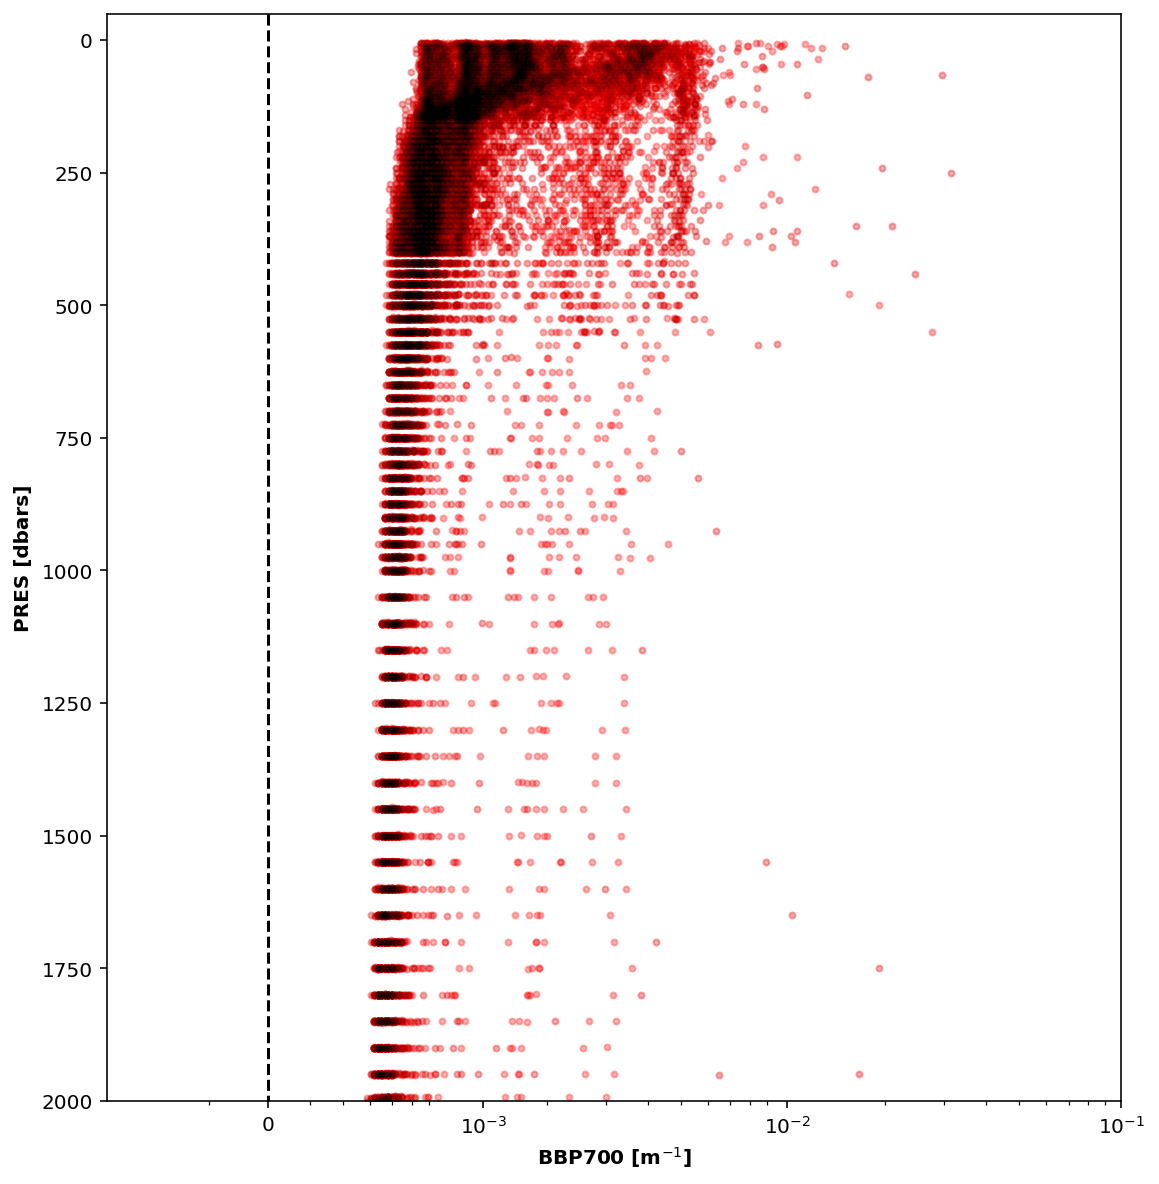

In [23]:
# %matplotlib widget
iN = 1#int(iall.size/3.) # step size to make plotting faster
fig = plt.figure(figsize=(20,10))
xmin = 0.0001
xmax = 0.1
xoff = 0.0003
ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.array(all_BBP700)[:][::iN] + xoff, np.array(all_PRES)[:][::iN], 'ro', ms=3, mfc='r', alpha=0.3)
ax1.plot(np.array(all_BBP700)[iQCle2][::iN] + xoff, np.array(all_PRES)[iQCle2][::iN], 'ko', ms=3, alpha=0.03)
ax1.plot((xoff, xoff), (-50, 2000), 'k--')
ax1.set_ylim([-50, 2000])
# ax1.set_xlim([-0.0003, 0.1])
ax1.set_xlim([xmin, xmax])
ax1.invert_yaxis()
ax1.set_xscale('log')
ax1.set_xlabel('BBP700 [m'+'$^{-1}$'+']', fontweight='bold')
ax1.set_ylabel('PRES [dbars]', fontweight='bold')
xts = list(np.asarray([0, 1e-3, 1e-2, 1e-1])+xoff)
xtklbls = ('0',  '10'+'$^{-3}$', '10'+'$^{-2}$', '10'+'$^{-1}$')
plt.xticks(xts, xtklbls)
plt.rcParams.update({'font.size': 20})


gc.collect()
    

In [24]:
def plot_iQC(x1, x2, y1, y2):


    # %matplotlib widget
    fig = plt.figure(figsize=(20,10))
    xmin = 0.0001
    xmax = 0.1
    xoff = 0.0003
    ax1 = fig.add_subplot(1,2,1)

    ax1.plot(x1 + xoff, y1, 'o', ms=3, alpha=0.03, color='b')
    ax1.plot(x2 + xoff, y2, 'ro', ms=3, alpha=0.1)

    ax1.plot((xoff, xoff), (-50, 2000), 'k--')

    ax1.set_ylim([-50, 2000])
    # ax1.set_xlim([-0.0003, 0.1])
    ax1.set_xlim([xmin, xmax])
    ax1.invert_yaxis()
    ax1.set_xscale('log')
    ax1.set_xlabel('BBP700 [m'+'$^{-1}$'+']', fontweight='bold')
    ax1.set_ylabel('PRES [dbars]', fontweight='bold')
    xts = list(np.asarray([0, 1e-3, 1e-2, 1e-1]) + xoff)
    xtklbls = ('0',  '10'+'$^{-3}$', '10'+'$^{-2}$', '10'+'$^{-1}$')
    plt.xticks(xts, xtklbls)
    plt.rcParams.update({'font.size': 20})

    gc.collect()


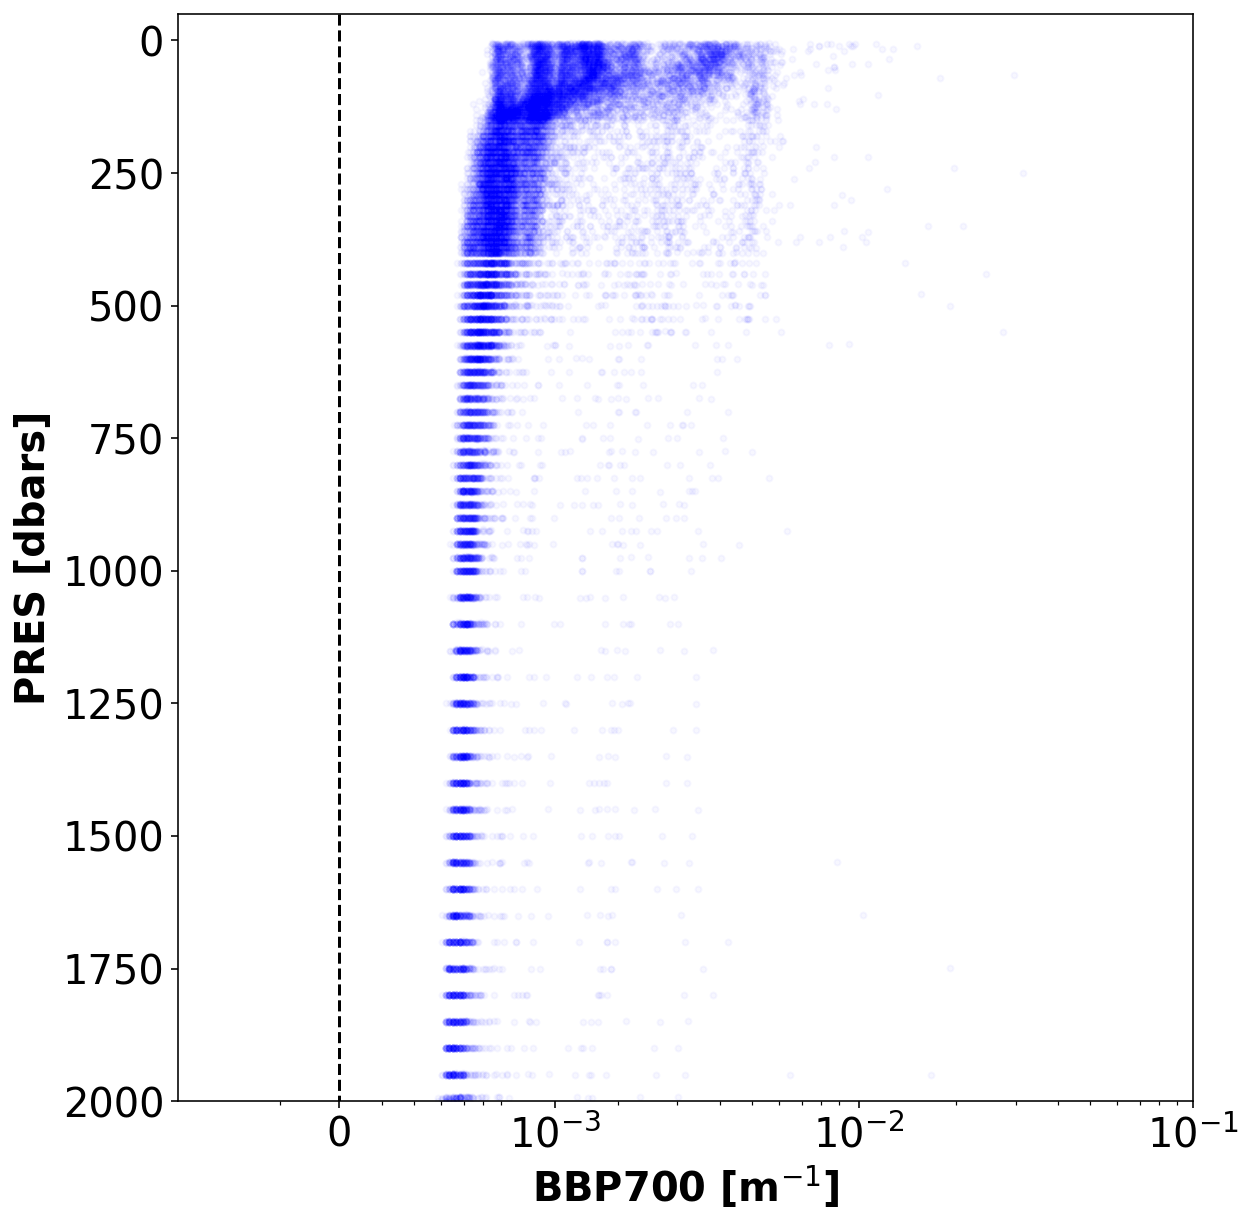

In [25]:
# plots results for Global range test (A)
iN = 1
x1 = np.array(all_BBP700)[:][::iN]
x2 = np.array(all_BBP700)[iQCge3][iA][::]
y1 = np.array(all_PRES)[:][::iN]
y2 = np.array(all_PRES)[iQCge3][iA][::]
plot_iQC(x1, x2, y1, y2)

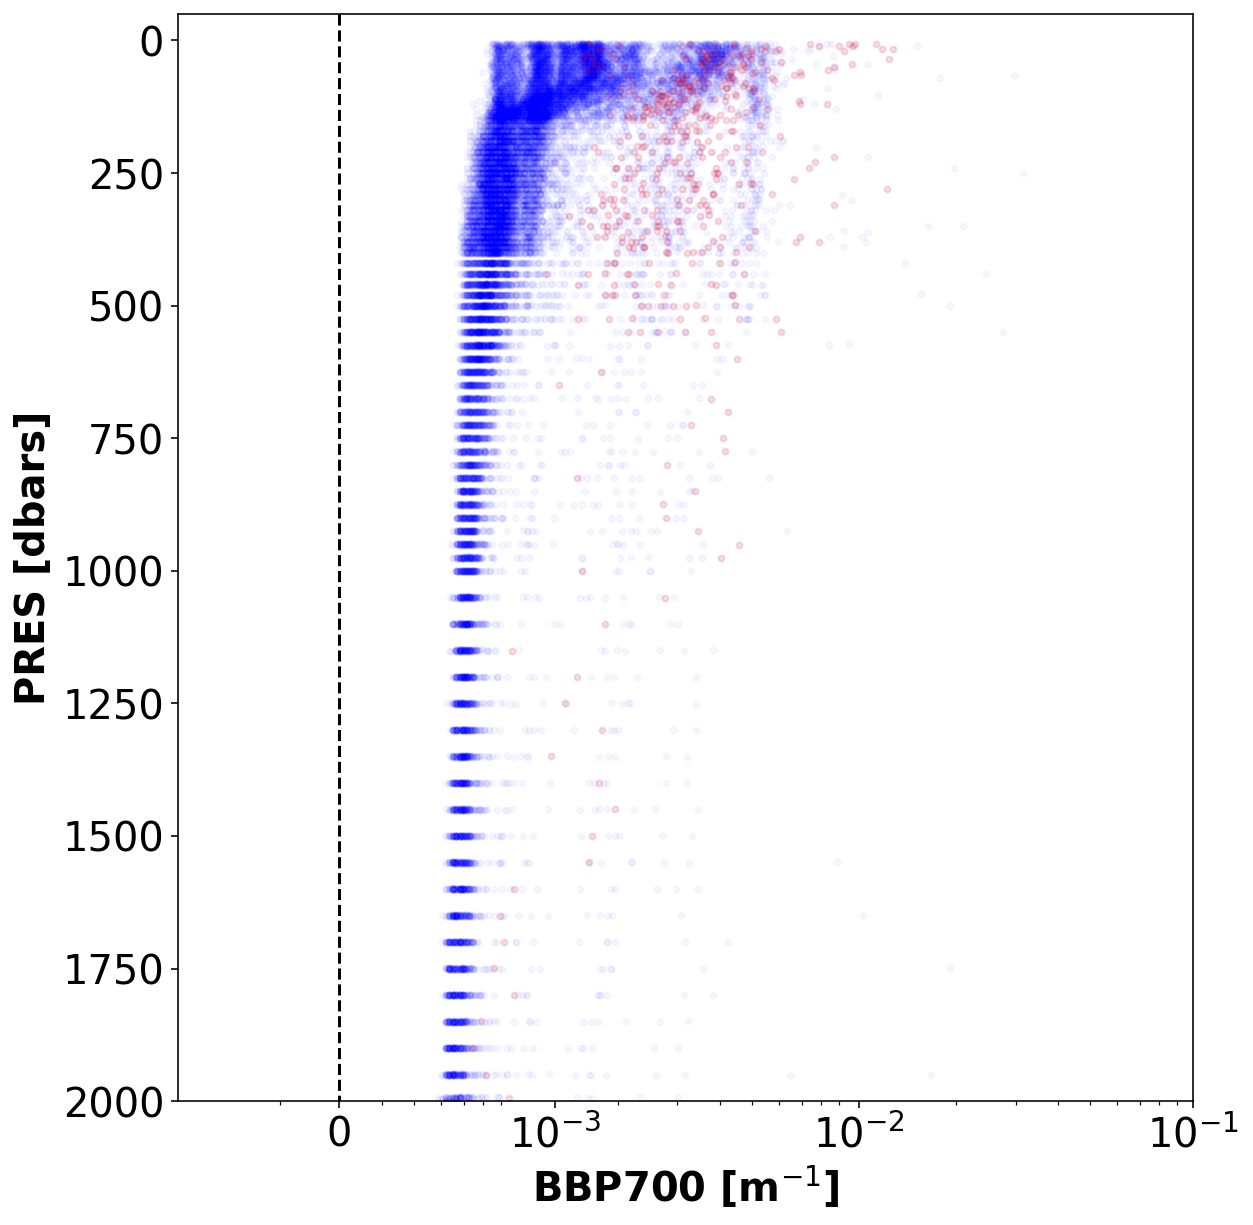

In [26]:
# plots results for test (B)
# x1 = np.array(all_BBP700)[:][::iN]
x2 = np.array(all_BBP700)[iQCge3][iB][::]
# y1 = np.array(all_PRES)[:][::iN]
y2 = np.array(all_PRES)[iQCge3][iB][::]
plot_iQC(x1, x2, y1, y2)

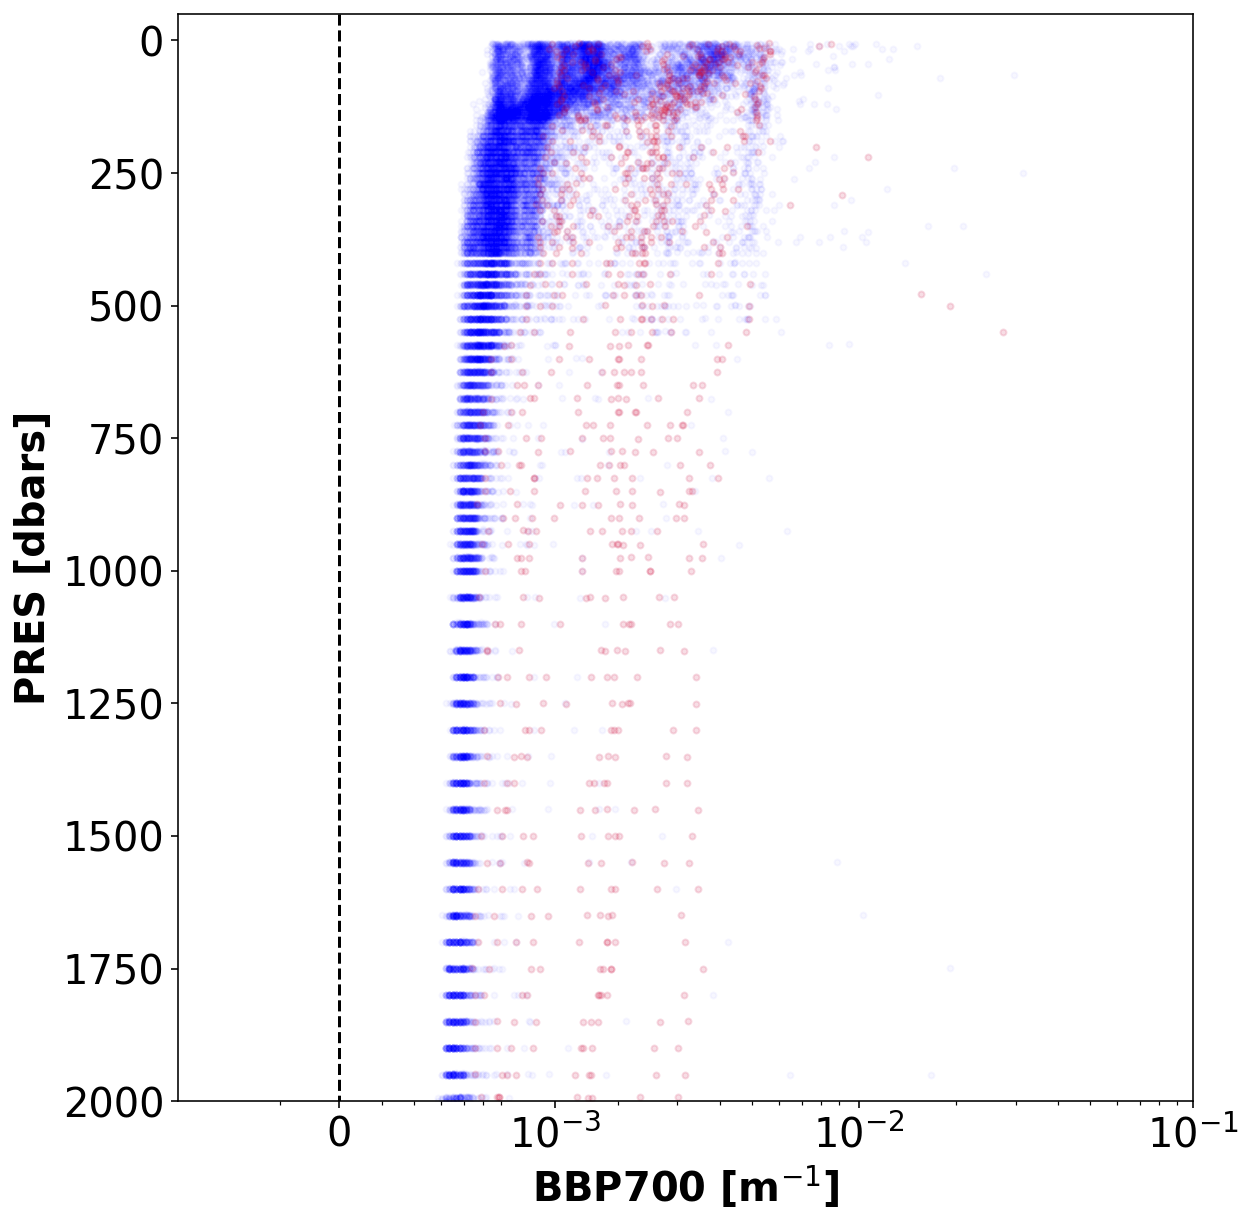

In [27]:
# plots results for test (C)
# x1 = np.array(all_BBP700)[:][::iN]
x2 = np.array(all_BBP700)[iQCge3][iC][::]
# y1 = np.array(all_PRES)[:][::iN]
y2 = np.array(all_PRES)[iQCge3][iC][::]
plot_iQC(x1, x2, y1, y2)

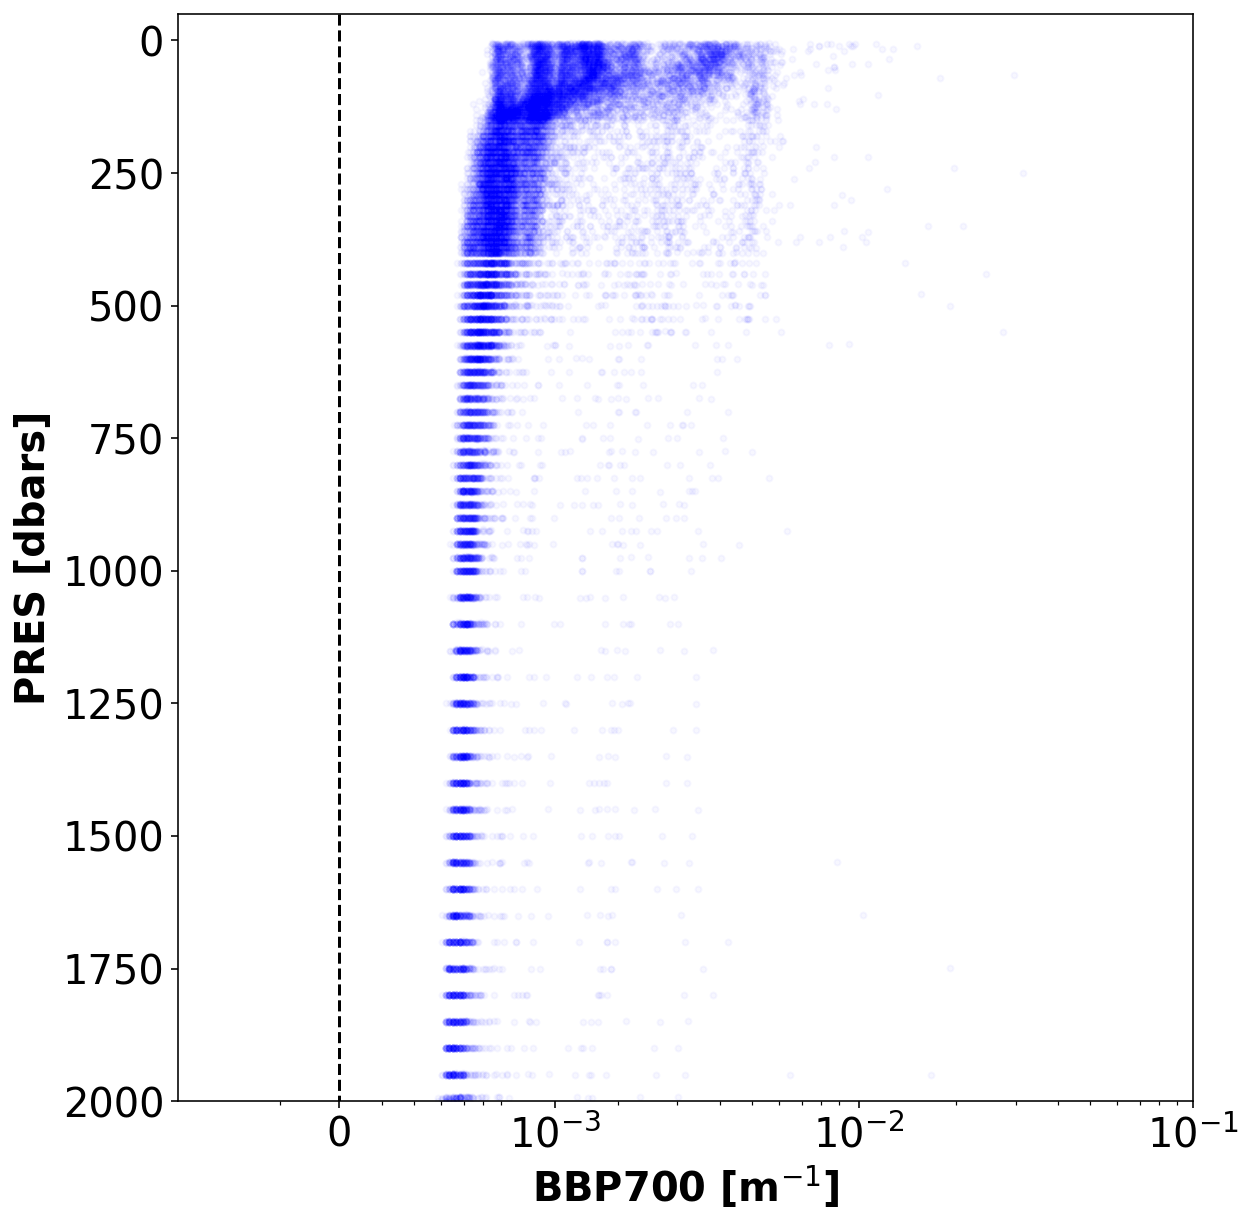

In [28]:
# plots results for test (D)
# x1 = np.array(all_BBP700)[:][::iN]
x2 = np.array(all_BBP700)[iQCge3][iD][::]
# y1 = np.array(all_PRES)[:][::iN]
y2 = np.array(all_PRES)[iQCge3][iD][::]
plot_iQC(x1, x2, y1, y2)

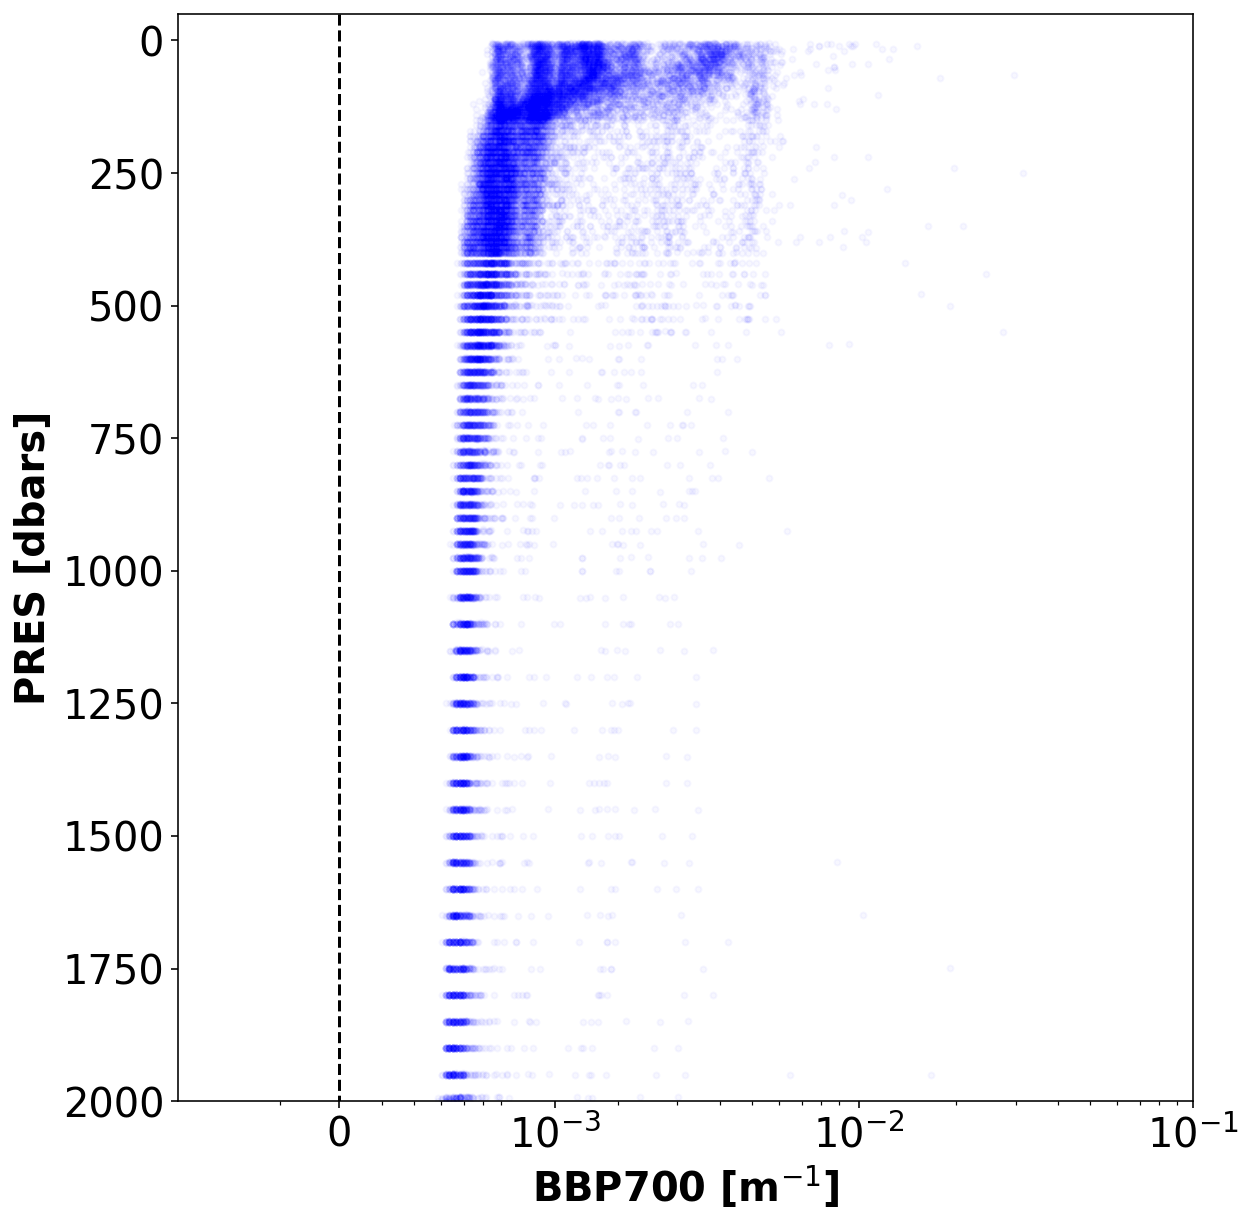

In [29]:
# plots results for test (E)
# x1 = np.array(all_BBP700)[:][::iN]
x2 = np.array(all_BBP700)[iQCge3][iE][::]
# y1 = np.array(all_PRES)[:][::iN]
y2 = np.array(all_PRES)[iQCge3][iE][::]
plot_iQC(x1, x2, y1, y2)

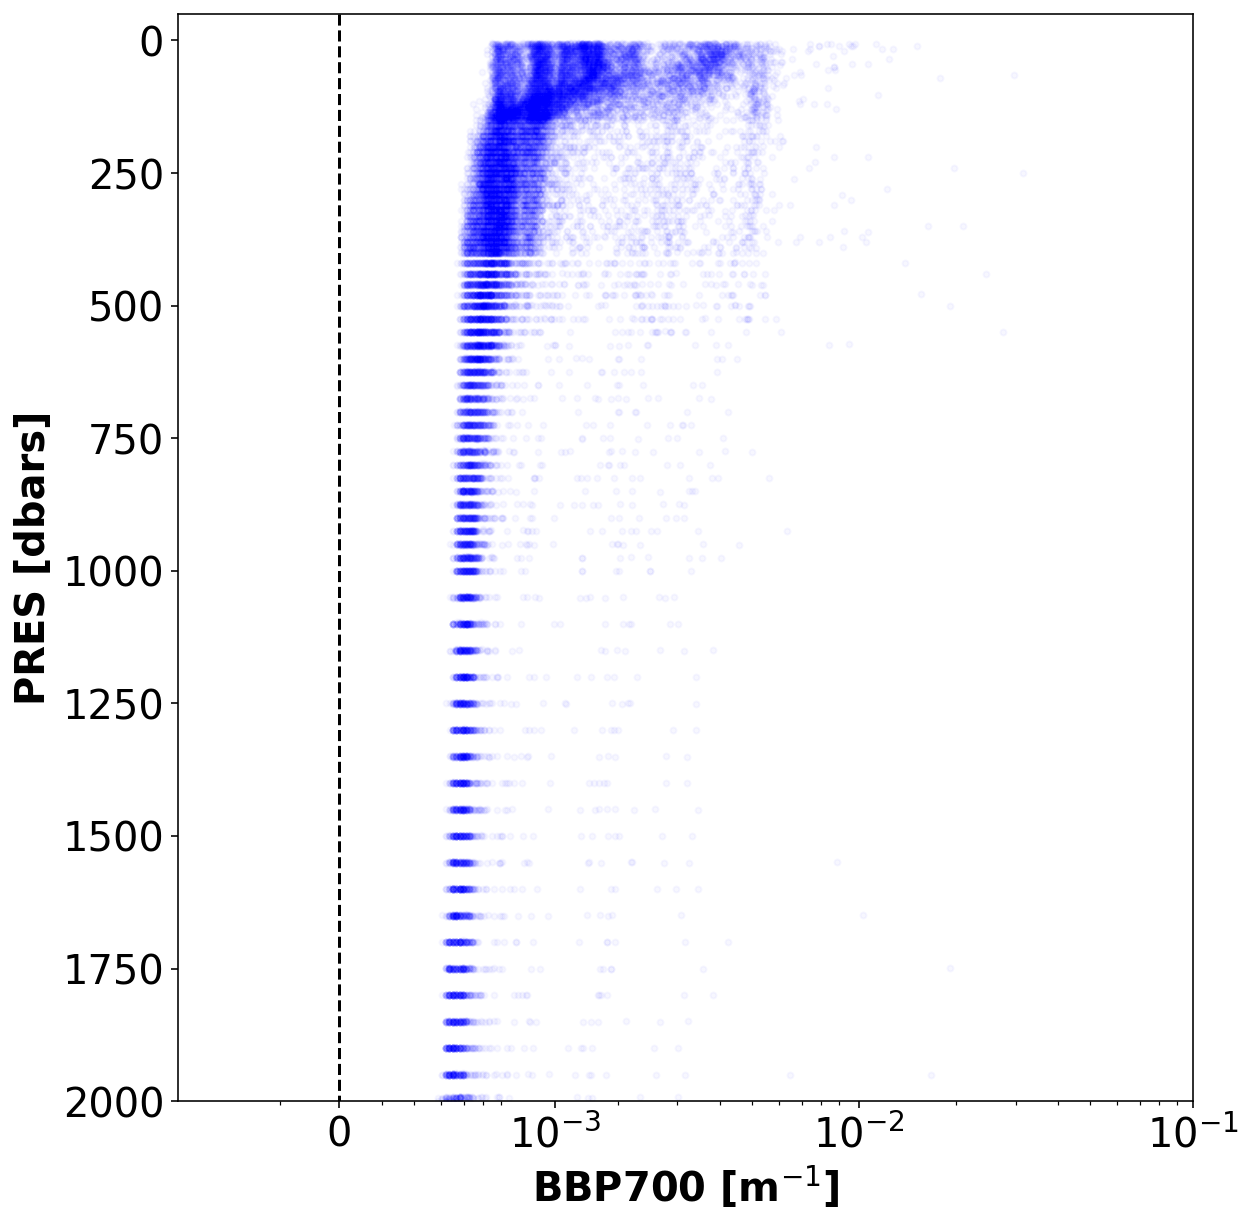

In [30]:
# plots results for test (F)
# x1 = np.array(all_BBP700)[:][::iN]
x2 = np.array(all_BBP700)[iQCge3][iF][::]
# y1 = np.array(all_PRES)[:][::iN]
y2 = np.array(all_PRES)[iQCge3][iF][::]
plot_iQC(x1, x2, y1, y2)

In [31]:
# del all_PRES, all_BBP700, all_BBP700_QC_flag, all_BBP700_1st_fail

12740

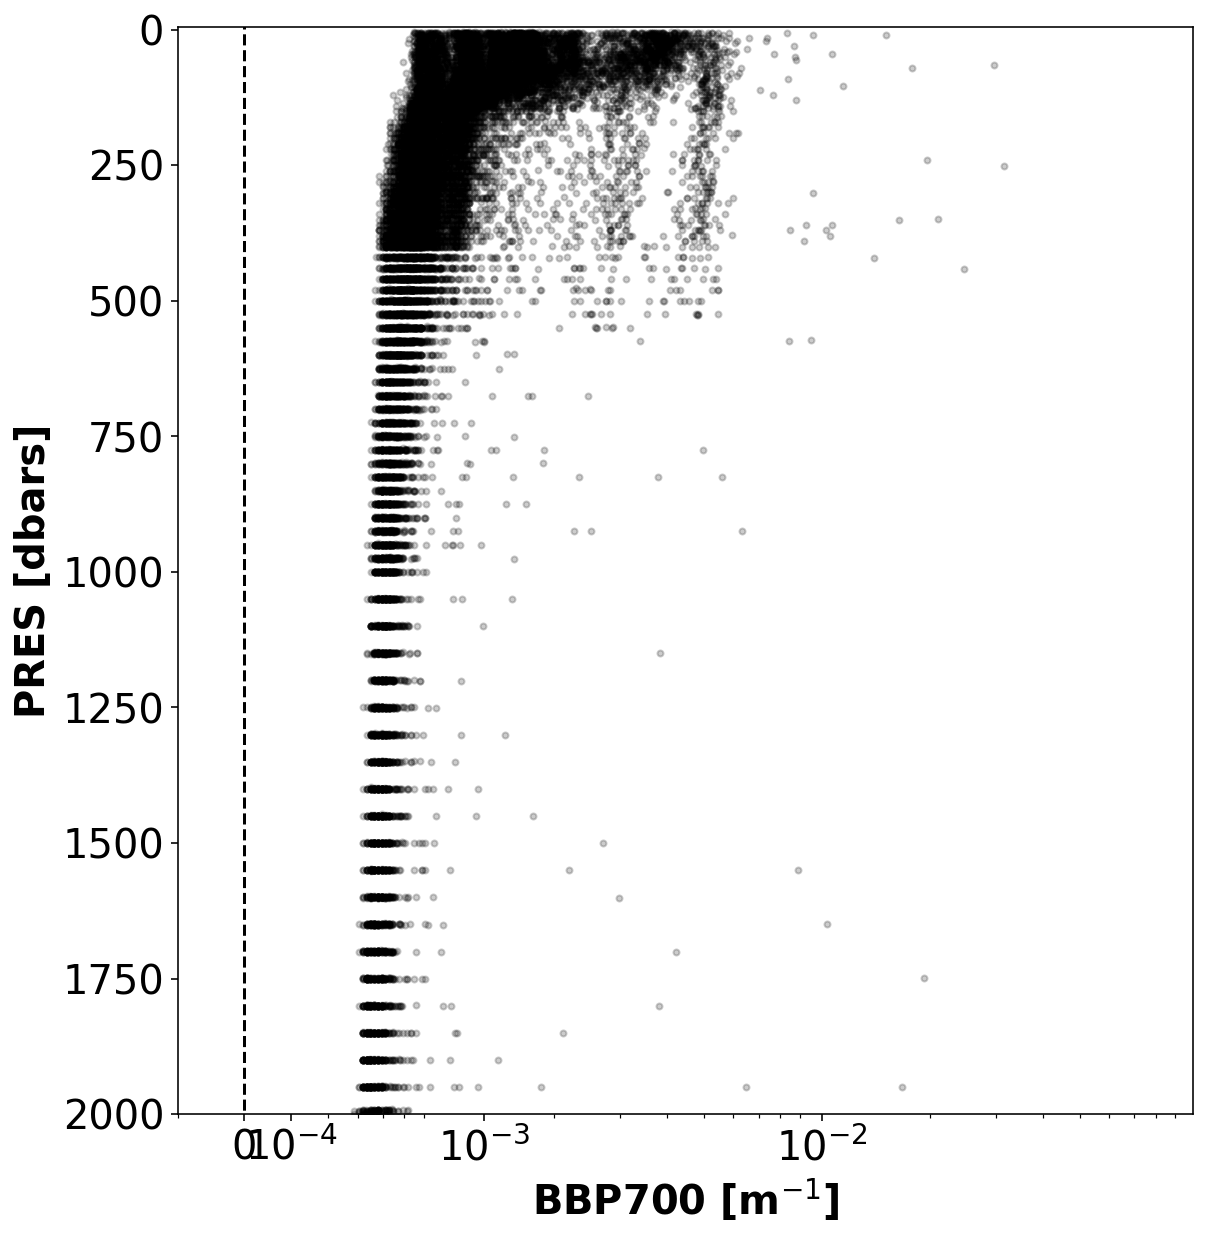

In [32]:
# %matplotlib widget
iN = 1#int(iall.size/3.) # step size to make plotting faster
fig = plt.figure(figsize=(20,10))
xmin = 0.0002
xmax = 0.1
xoff = 0.0003
ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.array(all_BBP700)[iQCle2][::iN]+xoff, np.array(all_PRES)[iQCle2][::iN], 'ko', ms=3, alpha=0.2)
ax1.plot((xoff, xoff), (-50, 2000), 'k--')
ax1.set_ylim([-5, 2000])

ax1.set_xlim([xmin, xmax])
ax1.invert_yaxis()
ax1.set_xscale('log')
ax1.set_xlabel('BBP700 [m'+'$^{-1}$'+']', fontweight='bold')
ax1.set_ylabel('PRES [dbars]', fontweight='bold')
xts = list(np.asarray([0, 1e-4, 1e-3, 1e-2]) + xoff)
xtklbls = ('0',  '10'+'$^{-4}$', '10'+'$^{-3}$', '10'+'$^{-2}$')
plt.xticks(xts, xtklbls)
plt.rcParams.update({'font.size': 20})


gc.collect()
    